# Demonstrate Positional Bias

Our goal here is to quantify positional bias inherrent in our LLM.

# Setup

In [1]:
import logging
from pathlib import Path
from time import perf_counter_ns as timer

from pandas import DataFrame
import rich
from rich.table import Table
from tqdm import tqdm

import llm_mcq_bias as lmb
from llm_mcq_bias.datasets.mmlu import Evaluation, OPTIONS
from llm_mcq_bias.models import llama_323b as generator

In [2]:
def print_table(rows):
    table = Table(*[k for k in rows[0]], box=rich.box.SIMPLE)
    for row in rows:
        table.add_row(*[str(v) for v in row.values()])
    rich.print(table)

In [3]:
project_path = Path("../")
datasets_path = project_path / ".build" / "datasets"

logger = logging.getLogger(__name__)

In [4]:
# Warm up model
generator(
    prompt="What is the capital of Massachusetts? Answer in one word.",
    options={"num_predict": 1},
)

'Boston'

# Demonstrate Bias

In [5]:
# Number of iterations
n_epochs = 3

# Number of questions to sample
n_questions = 240

llm_options = {
    # Limit output tokens to avoid waiting for invalid responses
    "num_predict": 10,
    # Disable token sampling
    "top_k": 1,
}

In [6]:
# Load example questions
examples = lmb.datasets.mmlu.load_dataset(datasets_path, segment="dev")

# Debias example answer distribution
examples = lmb.datasets.mmlu.normalize_example_answers(examples)

# Load test questions
questions = lmb.datasets.mmlu.load_dataset(datasets_path, segment="test")

In [7]:
def benchmark(
    description: str,
    *,
    examples: DataFrame,
    questions: DataFrame,
    generator_options: dict,
):
    n = len(questions)

    start_time = timer()

    # Answer and evaluate each question
    correct, errors = 0, 0
    for _, mcq in tqdm(questions.iterrows(), total=n, desc=description):
        # Generate prompt
        prompt = lmb.datasets.mmlu.generate_prompt(examples, mcq)

        # Generate answer
        response = lmb.models.llama_323b(prompt=prompt, options=generator_options)

        # Evaluate answer
        evaluation = lmb.datasets.mmlu.evaluate_response(mcq, response)
        if evaluation is Evaluation.CORRECT:
            correct += 1
        elif evaluation is Evaluation.ERROR:
            errors += 1

    duration = timer() - start_time

    # Derive metrics
    metrics = {
        "n": n,
        "correct": correct,
        "errors": errors,
        "accuracy": correct / (n - errors),
        "error_rate": errors / n,
        "rps": 1000000000 * n / duration,
    }

    return metrics

### Verify Stable Benchmark Results

Let's make sure our benchmark process produces consistent results when run against the same inputs.

<Axes: xlabel='answer'>

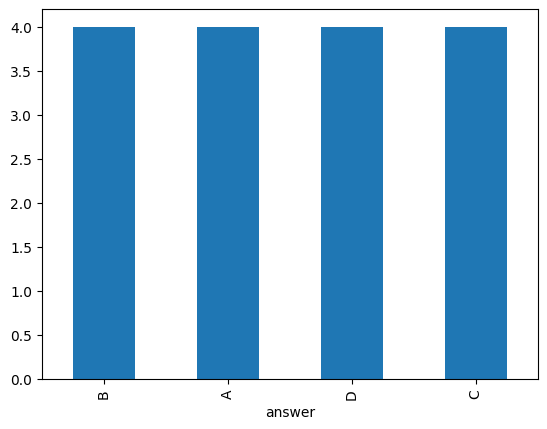

In [8]:
# Sample questions
selected_questions = questions.sample(n=16)

# Debias answer distribution
selected_questions = lmb.datasets.mmlu.normalize_question_answers(selected_questions)

# Plot answer distribution
selected_questions.answer.value_counts().plot.bar()

In [9]:
# Print example prompt
print(lmb.datasets.mmlu.generate_prompt(examples, selected_questions.iloc[0]))

You are a robot that only outputs JSON. You reply in JSON format with the field 'answer'. For example, the following are multiple choice questions about clinical knowledge.

Example Question: How many attempts should you make to cannulate a patient before passing the job on to a senior colleague, according to the medical knowledge of 2020?

A) 2
B) 3
C) 4
D) 1

Example Answer: {"answer": "A"}

Example Question: What is the difference between a male and a female catheter?

A) Male and female catheters are different colours.
B) Female catheters are longer than male catheters.
C) Male catheters are bigger than female catheters.
D) Male catheters are longer than female catheters.

Example Answer: {"answer": "D"}

Example Question: In the assessment of the hand function which of the following is true?

A) Abduction of the thumb is supplied by spinal root T2
B) Opposition of the thumb by opponens policis is supplied by spinal root T1
C) Finger adduction is supplied by the median nerve
D) Fin

In [10]:
%%time

rows = []
for i in range(n_epochs):
    # Run benchmark
    metrics = benchmark(
        f"epoch {i}",
        examples=examples,
        questions=selected_questions,
        generator_options=llm_options,
    )

    rows.append(metrics)

print_table(rows)

epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


 n    correct   errors   accuracy   error_rate   rps                 
 ──────────────────────────────────────────────────────────────────── 
  16   6         0        0.375      0.0          1.1741176262959345  
  16   6         0        0.375      0.0          1.069025280876225   
  16   6         0        0.375      0.0          1.0433043721051178

CPU times: user 137 ms, sys: 26 ms, total: 163 ms
Wall time: 43.9 s


## Estimate Positional Bias

In [11]:
%%time

# Repeat over multiple iterations
rows = []
for _ in range(n_epochs):
    # Sample questions
    selected_questions = questions.sample(n=n_questions)

    # Debias answer distribution
    selected_questions = lmb.datasets.mmlu.normalize_question_answers(
        selected_questions
    )

    # Initialize metrics
    metrics = {}

    # Record performance w/ original data
    metrics["uniform"] = benchmark(
        "uniform",
        examples=examples,
        questions=selected_questions,
        generator_options=llm_options,
    )

    # Record performance w/ answers shifted to each position
    for option in OPTIONS:
        # Swap answers to selected option
        q = lmb.datasets.mmlu.swap_options(selected_questions, option)

        metrics[option] = benchmark(
            option,
            examples=examples,
            questions=q,
            generator_options=llm_options,
        )

    rows.append(metrics)

A: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [03:07<00:00,  1.28it/s]

CPU times: user 8.43 s, sys: 988 ms, total: 9.42 s
Wall time: 46min 25s


In [13]:
table = Table("uniform", "A", "B", "C", "D", box=rich.box.SIMPLE)
for row in rows:
    baseline = row["uniform"]["accuracy"]
    offsets = {k: row[k]["accuracy"] - baseline for k in OPTIONS}
    colors = {option: "black" for option in OPTIONS}
    colors |= {option: "red" for option in OPTIONS if offsets[option] <= -0.05}
    colors |= {option: "green" for option in OPTIONS if offsets[option] >= 0.05}
    table.add_row(
        f"{baseline:0.2f}",
        f"[{colors['A']}]{offsets['A']:0.2f}[/{colors['A']}]",
        f"[{colors['B']}]{offsets['B']:0.2f}[/{colors['B']}]",
        f"[{colors['C']}]{offsets['C']:0.2f}[/{colors['C']}]",
        f"[{colors['D']}]{offsets['D']:0.2f}[/{colors['D']}]",
    )

rich.print(table)

 uniform   A      B      C      D      
 ────────────────────────────────────── 
  0.58      0.02   0.04   0.04   -0.11  
  0.53      0.07   0.09   0.06   -0.04  
  0.54      0.04   0.07   0.03   -0.08